### Import required libraries

In [127]:
import pandas as pd
import numpy as np
from sodapy import Socrata
import matplotlib.pyplot as plt
import datetime as dt

### Chicago API, by Socrata
#### https://dev.socrata.com/foundry/data.cityofchicago.org/ydr8-5enu
This dataset includes information about currently-valid building permits issued by the City of Chicago from 2006 to the present. 
Building permits are issued subject to payment of applicable fees. All communication with the API is done through HTTPS, and errors are communicated through HTTP response codes. Available response types include JSON, XML, and CSV, which are selectable by the "extension" (.json, etc.) on the API endpoint or through content-negotiation with HTTP Accepts headers.

In [128]:
# Uses the sodapy library to fetch the result from the Socrata API
client = Socrata("data.cityofchicago.org", None)

results = client.get("ydr8-5enu", limit=1000)

# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)
results_df.to_csv('contracts.csv', encoding = 'UTF-8', index = False)

### Load the csv data to a dataframe

In [129]:
contracts_df = pd.read_csv("contracts.csv")
contracts_df.isnull().sum()

id                          0
permit_                     0
permit_type                 0
review_type                 0
application_start_date      3
                         ... 
contact_12_name           999
contact_12_city           999
contact_12_state          999
contact_12_zipcode        999
pin8                      999
Length: 99, dtype: int64

### Data Cleaning and Analysis
1. Dropped the columns which are not useful in the analysis
2. Fill the null values for some columns as shown below.
3. Remove words like permit and contractor from permit_type and contact_1_type to get the required names.
4. Convert the date time fields to date format.
5. Remove the rows which have null application start date
6. Save the dataframe to a csv file.

In [130]:
drop1 = contracts_df.drop(contracts_df.loc[:,'street_number':'subtotal_waived'], axis='columns')
drop2 = drop1.drop(drop1.loc[:, 'contact_1_state':'pin8'].columns, axis='columns')
drop2.isnull().sum()

id                         0
permit_                    0
permit_type                0
review_type                0
application_start_date     3
issue_date                 0
processing_time            3
total_fee                  0
contact_1_type             8
contact_1_name             8
contact_1_city            10
dtype: int64

In [131]:
drop2["contact_1_type"].fillna("Unknown",inplace = True)
drop2["contact_1_name"].fillna("Unknown",inplace = True)
drop2["contact_1_city"].fillna("Other",inplace = True)
drop2["processing_time"].fillna("0", inplace = True)
drop2['permit_type'] = drop2['permit_type'].str.replace('PERMIT -', '')
drop2['contact_1_type'] = drop2['contact_1_type'].str.replace('CONTRACTOR-', '')
drop2['application_start_date'] = pd.to_datetime(drop2['application_start_date'], infer_datetime_format=True)
drop2['application_start_date'] = drop2['application_start_date'].dt.date
drop2['issue_date'] = pd.to_datetime(drop2['issue_date'], infer_datetime_format=True)
drop2['issue_date'] = drop2['issue_date'].dt.date
drop2= drop2[drop2['application_start_date'].notna()]
drop2.to_csv('contracts_clean.csv', encoding = 'UTF-8', index = False)

### Load the cleaned dataset to a dataframe.

In [132]:
clean_df = pd.read_csv("contracts_clean.csv", index_col="id")
clean_df.describe()

,permit_,processing_time,total_fee
count,9.970000e+02,997.000000,997.000000
mean,1.000635e+08,29.586760,720.879448
std,5.500488e+06,131.296706,3450.942640
min,5.369700e+04,0.000000,40.000000
25%,1.001914e+08,0.000000,50.000000
50%,1.003069e+08,0.000000,135.000000
75%,1.004583e+08,14.000000,300.000000
max,1.008582e+08,2159.000000,61972.500000


In [133]:
permit_type = clean_df["permit_type"].value_counts().rename_axis('permit_type').to_frame('counts')
permit_type

,counts
permit_type,
ELECTRIC WIRING,447
EASY PERMIT PROCESS,199
RENOVATION/ALTERATION,123
SIGNS,115
NEW CONSTRUCTION,35
WRECKING/DEMOLITION,29
SCAFFOLDING,17
ELEVATOR EQUIPMENT,15
REINSTATE REVOKED PMT,14


In [134]:
contact_1_city = clean_df['contact_1_city'].value_counts()[clean_df['contact_1_city'].value_counts()>5].rename_axis('contact_1_city').to_frame('counts')
contact_1_city

,counts
contact_1_city,
CHICAGO,454
ADDISON,37
OAK BROOK,23
CHICAGO X,22
ELMHURST,19
ELGIN,18
CHGO,18
DES PLAINES,17
NORTHBROOK,12


In [135]:
contact_1_name = clean_df['contact_1_name'].value_counts()[clean_df['contact_1_name'].value_counts()>=10].rename_axis('contact_1_name').to_frame('counts')
contact_1_name

,counts
contact_1_name,
DEPAUL UNIVERSITY,91
DOYLE SIGINS INC,30
ILLINOIS BELL / AT&T,28
A.D.T. INC.,20
PLAZA AZTECA / PLAZA GARIBALDI PLAZA AZTECA / PLAZA GARIBALDI,12
HM WITT,11
"ADVENT SYSTEMS, INC.",11
SURE LIGHT SERVICE CO,11


### Data Visualization using Pandas

### Bar chart illustrating the volume of building contracts vs year in decreasing order of volume 

Text(0.5, 1.0, 'Volume of building contracts vs year in decreasing order of volume')

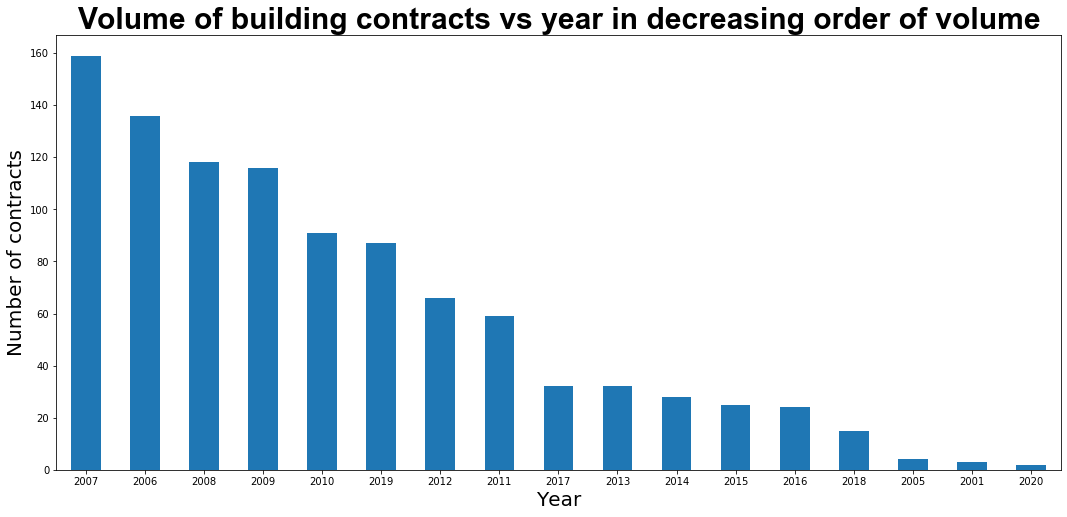

In [136]:
clean_df['application_start_date'] = pd.to_datetime(clean_df['application_start_date'], infer_datetime_format=True)
clean_df['application_start_date'] = clean_df['application_start_date'].dt.year
counts = clean_df['application_start_date'].value_counts().sort_values(ascending = False)
barh_plot = counts.plot.bar(figsize=(18,8),rot=0)
barh_plot.set_xlabel("Year", fontsize =20)
barh_plot.set_ylabel("Number of contracts", fontsize =20)
barh_plot.set_title("Volume of building contracts vs year in decreasing order of volume",fontsize= 30, fontname="Arial", fontweight = "bold")

##### Conclusion:
The maximum number of contracts can be seen in the year 2007.

### Horizontal bar chart to display top 10 cities with highest volumes of building permits in Illinois.

Text(0.5, 1.0, 'Top 10 cities with highest volumes of building permits')

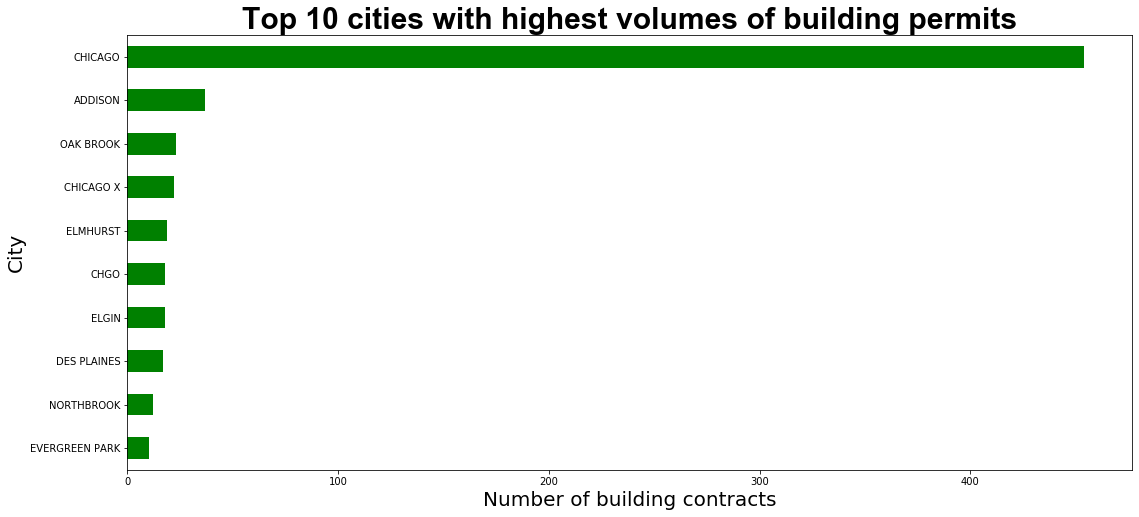

In [137]:
counts = clean_df["contact_1_city"].value_counts()[:10].sort_values()
barh_plot = counts.plot.barh(figsize=(18,8), color = "green")
barh_plot.set_xlabel("Number of building contracts", fontsize =20)
barh_plot.set_ylabel("City", fontsize =20)
barh_plot.set_title("Top 10 cities with highest volumes of building permits",fontsize= 30, fontname="Arial", fontweight = "bold")

##### Conclusion:
Chicago has the highest number of building permits in the U.S State of Illinois, with over 400 permits.

### Pie chart illustrating the top 5 valid permit types

Text(0.5, 1.0, 'Top 5 Valid Permit Types')

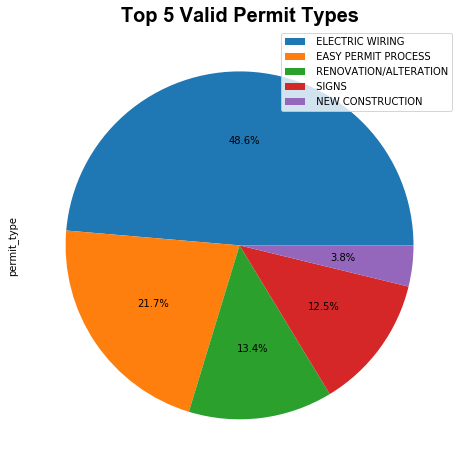

In [138]:
pie_plot = clean_df["permit_type"].value_counts()[:5].plot.pie(figsize=(40, 8),autopct='%1.1f%%', legend = True, labels = None)
pie_plot.set_title("Top 5 Valid Permit Types",fontsize= 20, fontname="Arial", fontweight = "bold")

##### Conclusion:
Electric wiring has the maximum number of permits. The top 5 permit types with maximum number of permits are electric wiring, easy permit process, renovation/alteration, signs and new construction.

### Horizontal bar chart to show the average total fee for each permit type

Text(0.5, 1.0, 'Average total fee for each permit type')

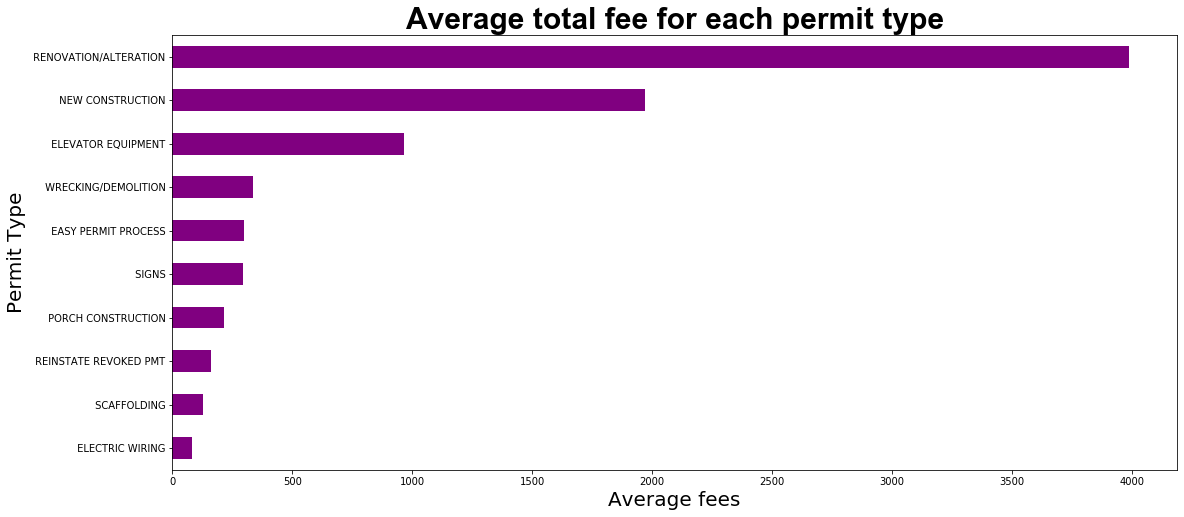

In [139]:
barh_plot = clean_df.groupby("permit_type")['total_fee'].mean().sort_values().plot(kind='barh', color = "purple", figsize=(18,8))
barh_plot.set_xlabel("Average fees", fontsize =20)
barh_plot.set_ylabel("Permit Type", fontsize =20)
barh_plot.set_title("Average total fee for each permit type",fontsize= 30, fontname="Arial", fontweight = "bold")

##### Conclusion:
Renovation/Alteration permit type has the highest average total fee, i.e. it is the most expensive permit type.

Electric Wiring has the least average total fee compared to all the permit types.

### Creating a subset of the original dataframe with contracts only specific to the city of Chicago.

In [140]:
chicago_df = clean_df[(clean_df["contact_1_city"] =="CHICAGO")]
chicago_df.sort_values(by = 'processing_time',ascending=False, inplace=True)
chicago_df

C:\Users\minib\Anaconda3\envs\jupyter\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,permit_,permit_type,review_type,application_start_date,issue_date,processing_time,total_fee,contact_1_type,contact_1_name,contact_1_city
id,,,,,,,,,,
1768463,100157690,ELECTRIC WIRING,EASY PERMIT WEB,2007,2008-11-19,674.0,40.0,ELECTRICAL,DEPAUL UNIVERSITY,CHICAGO
1779325,100163080,ELECTRIC WIRING,EASY PERMIT WEB,2007,2008-11-19,643.0,40.0,ELECTRICAL,DEPAUL UNIVERSITY,CHICAGO
1816528,100182905,ELECTRIC WIRING,EASY PERMIT WEB,2007,2008-09-24,474.0,40.0,ELECTRICAL,DEPAUL UNIVERSITY,CHICAGO
1816702,100183030,ELECTRIC WIRING,EASY PERMIT WEB,2007,2008-09-24,474.0,40.0,ELECTRICAL,DEPAUL UNIVERSITY,CHICAGO
2398868,100454729,SIGNS,SIGN PERMIT,2012,2014-01-28,446.0,2500.0,SIGN CONTRACTOR,LINCOLN SERVICES,CHICAGO
...,...,...,...,...,...,...,...,...,...,...
2683499,100610000,ELECTRIC WIRING,EASY PERMIT WEB,2015,2015-08-31,0.0,50.0,ELECTRICAL,K & A ELECTRIC,CHICAGO
2347459,100428055,ELECTRIC WIRING,EASY PERMIT WEB,2012,2012-02-14,0.0,100.0,ELECTRICAL,TOMIS ELECTRIC,CHICAGO
2391550,100451139,ELECTRIC WIRING,EASY PERMIT WEB,2012,2012-07-26,0.0,50.0,ELECTRICAL,D M D ELEC. CONST. LIGHTING &,CHICAGO


### Horizontal bar graph illustrating number of contracts for each permit type in the city of Chicago.

Text(0.5, 1.0, 'Number of contracts for each permit type in Chicago')

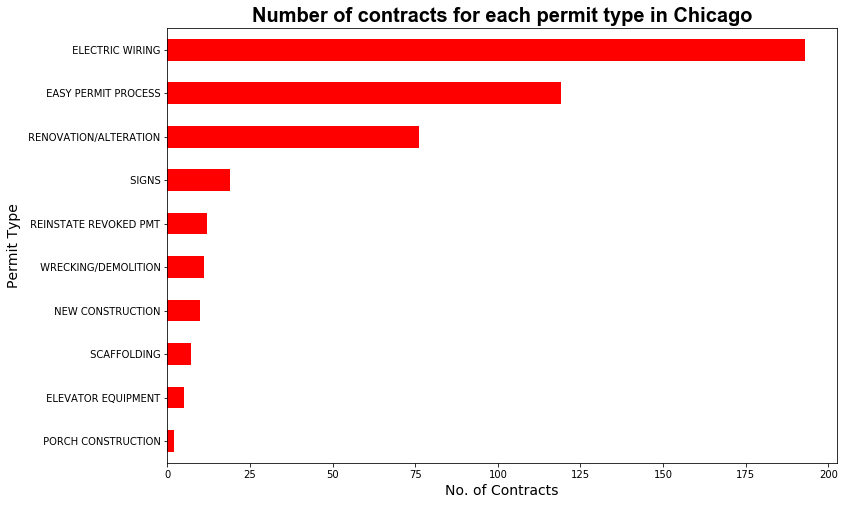

In [141]:
barh_plot = chicago_df['permit_type'].value_counts().sort_values().plot(kind='barh' , color = 'red', figsize=(12,8))
barh_plot.set_xlabel("No. of Contracts", fontsize =14)
barh_plot.set_ylabel("Permit Type", fontsize =14)
barh_plot.set_title("Number of contracts for each permit type in Chicago",fontsize= 20, fontname="Arial", fontweight = "bold")

#### Conclusion: 
Maximum number of contracts are for Electric Wiring permit type in the city of Chicago.

Porch construction permit type has the minimum number of contracts.

### Line graph showing Top 4 Contractors in the city of Chicago with maximum average processing time

C:\Users\minib\Anaconda3\envs\jupyter\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, 'Top 4 Contractors with maximum average processing time')

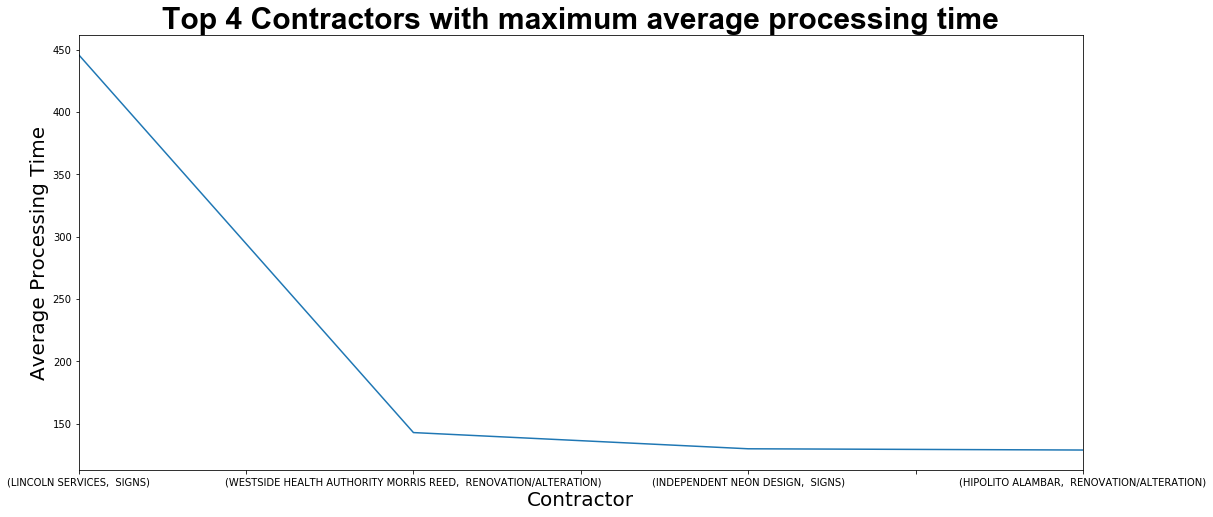

In [142]:
# creating a subset of the Chicago dataframe with only three columns permit_type, contact_1_name and processing_time
chicago_df2 = chicago_df[['contact_1_name','permit_type','processing_time']]
chicago_df2.sort_values(by = 'processing_time',ascending=False, inplace=True)
chicago_df2.set_index('contact_1_name')
line_plot = chicago_df2.groupby(["contact_1_name", "permit_type"])['processing_time'].mean().sort_values(ascending=False)[:4].plot.line(x='contact_1_name', y='processing_time', figsize=(18,8))
line_plot.set_xlabel("Contractor", fontsize =20)
line_plot.set_ylabel("Average Processing Time", fontsize =20)
line_plot.set_title("Top 4 Contractors with maximum average processing time",fontsize= 30, fontname="Arial", fontweight = "bold")


##### Conclusion: 
 The maximum average processing time is taken for SIGNS and Renovation/Alteration permits by contractors in the city of Chicago.
 
 LINCOLN SERVICES takes maximum time for processing SIGNS contracts.

### Overall Conclusion:
Based on the analysis above, we can see the number of permits issued each year, the most prominent types of permit issued in the state of Illinois,a comparison of average total fees for each permit type, the city which was issued the maximum number of valid permits. Further analysed the number of contracts for each permit type and contractors with maximum average processing time in Chicago, as it has the maximum total number of contracts. It gives an overall picture that the city of Chicago has the maximum number of valid permits issued and Electric Wiring permits are the most common valid permits, because they have the least total fee. 

### Further Analysis:
Further in-depth analysis can be carried out to study the comparison of the volume of permit types, processing time for different permits and the total fees charged for the permits for each city or suburb in Illinois over a range of years.